# Experiment Notebook: Sanity Checks

# Table of Contents
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: PCV Sanity Checks](#Analysis-1:-PCV-Sanity-Checks)

# Experiment Summary 

The purpose of this notebook is to...

# Experiment Assumptions

See [assumptions document](../../ASSUMPTIONS.md) for further details.

# Experiment Setup

We begin with several experiment-notebook-level preparatory setup operations:

* Import relevant dependencies
* Import relevant experiment templates
* Create copies of experiments
* Configure and customize experiments 

Analysis-specific setup operations are handled in their respective notebook sections.

In [1]:
# Import the setup module:
# * sets up the Python path
# * runs shared notebook configuration methods, such as loading IPython modules
import setup

import copy
import logging
import numpy as np
import pandas as pd
import plotly.express as px

import experiments.notebooks.visualizations as visualizations
from experiments.run import run
from experiments.utils import display_code

time: 879 ms (started: 2022-06-14 16:51:24 -04:00)


In [2]:
# Enable/disable logging
logger = logging.getLogger()
logger.disabled = False

time: 23.6 ms (started: 2022-06-14 16:51:25 -04:00)


In [3]:
# Import experiment templates
import experiments.default_experiment as default_experiment

time: 23.4 ms (started: 2022-06-14 16:51:25 -04:00)


In [4]:
# Inspect experiment template
display_code(default_experiment)

"""
The default experiment with default model Initial State, System Parameters, and Simulation Configuration.
The defaults are defined in their respective modules:
* Initial State in `model/state_variables.py`
* System Parameters in `model/system_parameters.py`
* Simulation Configuration in `experiments/simulation_configuration.py`
"""

from radcad import Simulation, Experiment, Backend

from model import model
from experiments.simulation_configuration import TIMESTEPS, DELTA_TIME, MONTE_CARLO_RUNS
from model.state_variables import setup_initial_state


# Create Model Simulation
simulation = Simulation(
    model=model,
    timesteps=TIMESTEPS,
    runs=MONTE_CARLO_RUNS
)
# Create Experiment of single Simulation
experiment = Experiment([simulation])
# Configure Simulation & Experiment engine
simulation.engine = experiment.engine
experiment.engine.backend = Backend.SINGLE_PROCESS
experiment.engine.deepcopy = True
experiment.engine.drop_substeps = True

simulation.before_subset = setup_initial_state
experiment.before_subset = setup_initial_state

time: 109 ms (started: 2022-06-14 16:51:25 -04:00)


In [5]:
# Create a simulation for each analysis
simulation_1 = copy.deepcopy(default_experiment.experiment.simulations[0])

time: 23.7 ms (started: 2022-06-14 16:51:25 -04:00)


In [6]:
# Experiment configuration
simulation_1.model.initial_state.update({})

simulation_1.model.params.update({})

time: 22 ms (started: 2022-06-14 16:51:25 -04:00)


# Analysis 1: PCV Sanity Checks

A simulation across 4 volatile asset price scenarios to validate PCV states and metrics.

In [7]:
# Analysis-specific setup
simulation_1.model.params.update({
    "volatile_asset_price_process": [
        lambda _run, _timestep: 2_000,
        lambda _run, timestep: 2_000 if timestep < 365 / 4 else (1_000 if timestep < 365 * 3/4 else 2_000),
        lambda _run, timestep: 2_000 * (1 + timestep * 0.2 / 365),
        lambda _run, timestep: 2_000 * (1 - timestep * 0.2 / 365),
    ],
})

time: 24.8 ms (started: 2022-06-14 16:51:25 -04:00)


In [8]:
# Experiment execution
df, exceptions = run(simulation_1)

2022-06-14 16:51:25,999 - root - INFO - Running experiment
2022-06-14 16:51:26,002 - root - INFO - Setting up initial state
2022-06-14 16:51:26,003 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-06-14 16:51:26,338 - root - INFO - Setting up initial state
2022-06-14 16:51:26,339 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-06-14 16:51:26,665 - root - INFO - Setting up initial state
2022-06-14 16:51:26,666 - root - INFO - Starting simulation 0 / run 0 / subset 2
2022-06-14 16:51:26,990 - root - INFO - Setting up initial state
2022-06-14 16:51:26,992 - root - INFO - Starting simulation 0 / run 0 / subset 3
2022-06-14 16:51:27,319 - root - INFO - Experiment complete in 1.3190288543701172 seconds
2022-06-14 16:51:27,320 - root - INFO - Post-processing results
2022-06-14 16:51:27,361 - root - INFO - Post-processing complete in 0.04158496856689453 seconds
time: 1.39 s (started: 2022-06-14 16:51:25 -04:00)


In [9]:
# Post-processing and visualizations

time: 23.8 ms (started: 2022-06-14 16:51:27 -04:00)


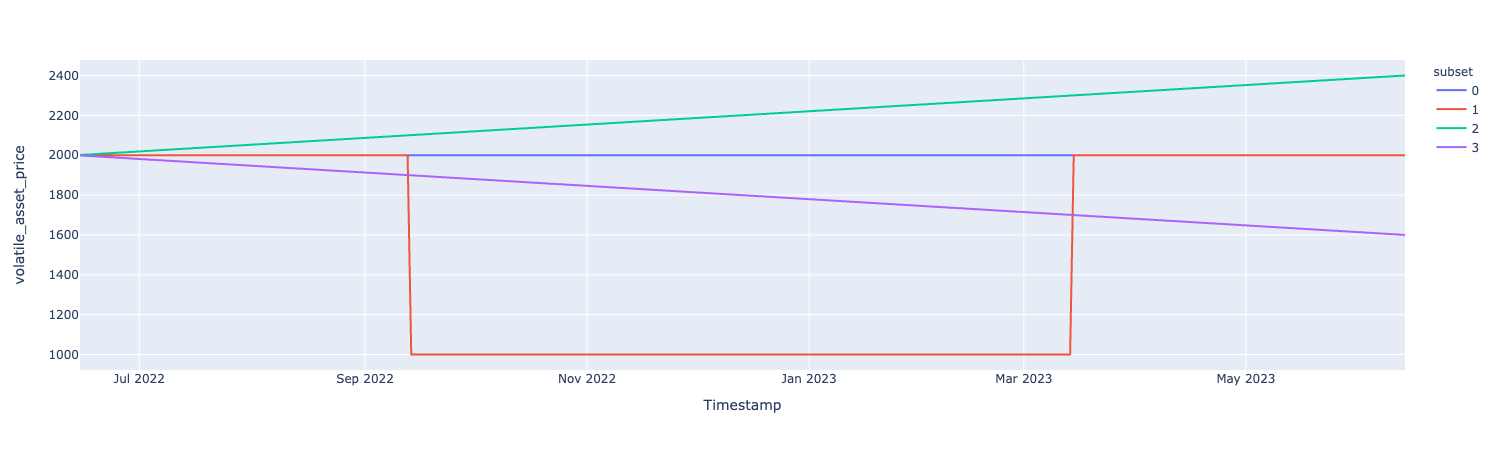

time: 1.14 s (started: 2022-06-14 16:51:27 -04:00)


In [10]:
fig = df.plot(y='volatile_asset_price', color='subset')

fig.update_xaxes(title='Timestamp')

/Users/bscholtz/workspace/CADLabs/fei-protocol-model/venv/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




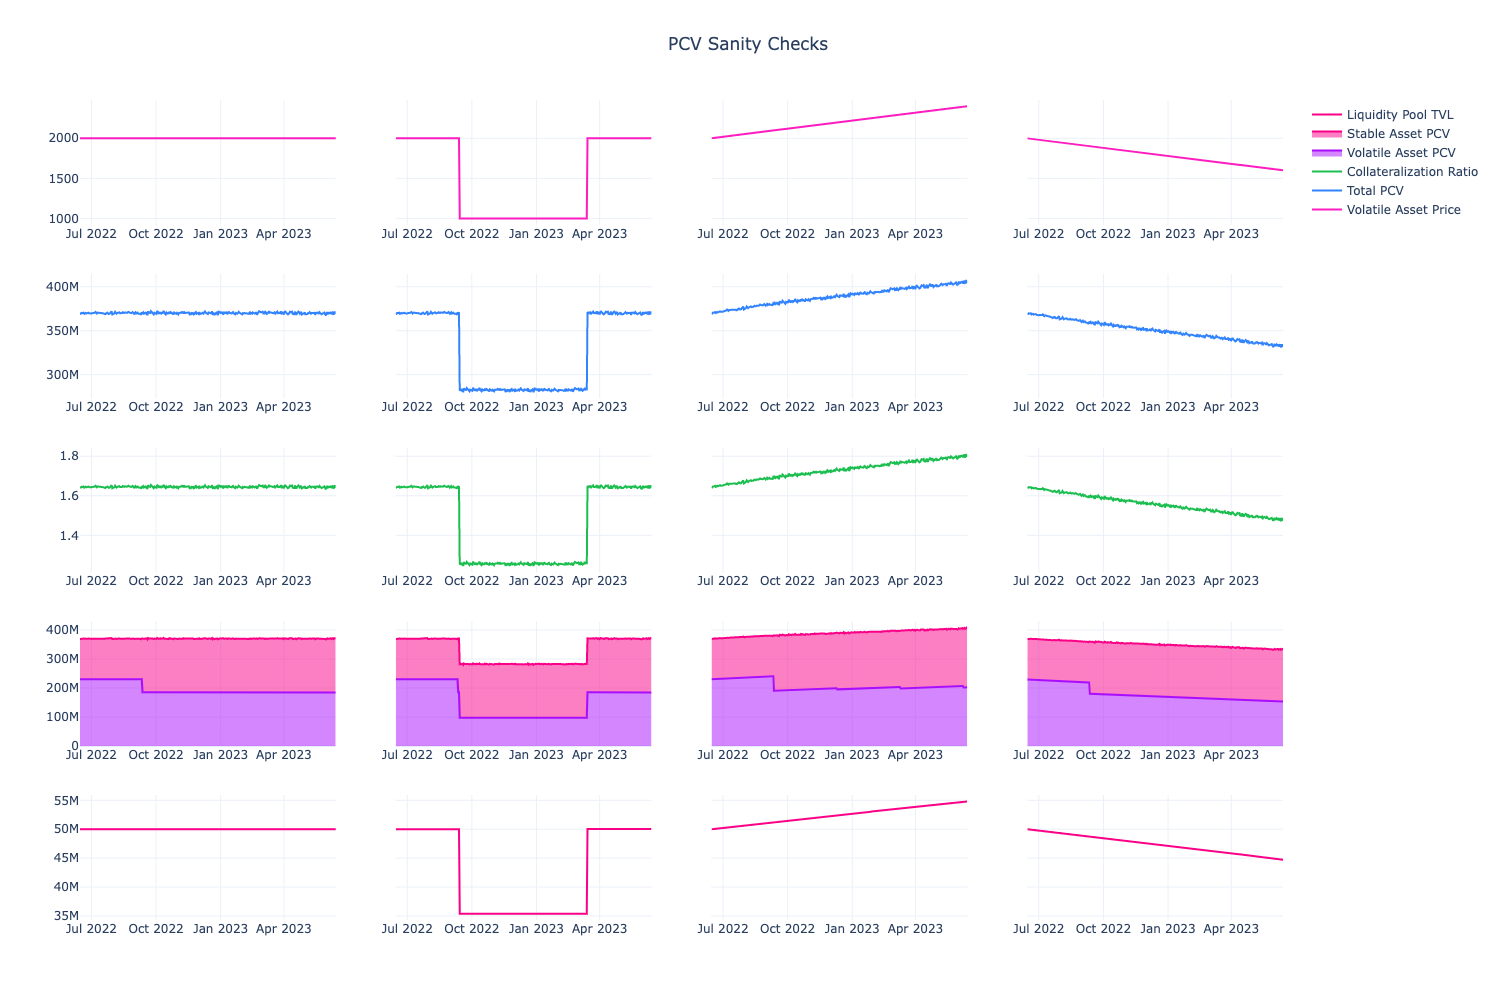

time: 733 ms (started: 2022-06-14 16:51:28 -04:00)


In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from experiments.notebooks.visualizations.plotly_theme import cadlabs_colorway_sequence
color_cycle = itertools.cycle(cadlabs_colorway_sequence)


fig = make_subplots(rows=5, cols=len(df.subset.unique()), shared_yaxes=True)

for subset in df.subset.unique():
    df_plot = df.query('subset == @subset')
    
    fig.add_trace(
        go.Line(
            x=df_plot.timestamp,
            y=df_plot.volatile_asset_price,
            name="Volatile Asset Price",
            line=dict(color=cadlabs_colorway_sequence[0]),
            showlegend=(True if subset == 0 else False),
        ),
        row=1, col=subset+1,
    )

    fig.add_trace(
        go.Line(
            x=df_plot.timestamp,
            y=df_plot.total_pcv,
            name="Total PCV",
            line=dict(color=cadlabs_colorway_sequence[1]),
            showlegend=(True if subset == 0 else False),
        ),
        row=2, col=subset+1
    )

    fig.add_trace(
        go.Line(
            x=df_plot.timestamp,
            y=df_plot.collateralization_ratio,
            name="Collateralization Ratio",
            line=dict(color=cadlabs_colorway_sequence[2]),
            showlegend=(True if subset == 0 else False),
        ),
        row=3, col=subset+1
    )
    
    fig.add_trace(
        go.Line(
            x=df_plot.timestamp,
            y=df_plot.total_volatile_asset_pcv,
            name="Volatile Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[3]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Line(
            x=df_plot.timestamp,
            y=df_plot.total_stable_asset_pcv,
            name="Stable Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Line(
            x=df_plot.timestamp,
            y=df_plot.liquidity_pool_tvl,
            name="Liquidity Pool TVL",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
        ),
        row=5, col=subset+1
    )


fig.update_layout(height=1000, title_text="PCV Sanity Checks")
fig.show()